<a href="https://colab.research.google.com/github/jee365/ESAA/blob/main/3_classification_0304.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##3.1 MNIST

DESCR 키: 데이터셋을 설명

data 키: 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열

target 키: 레이블 배열

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X,y= mnist['data'],mnist['target']
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

In [12]:
#데이터셋 이미지 하나 확인

import numpy as np
X, y = mnist['data'], mnist['target']
y = y.astype(np.int8) 

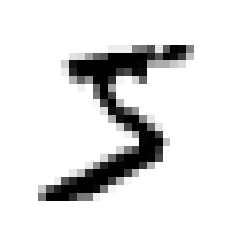

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.to_numpy()[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [15]:
y[0]

5

In [16]:
#train 데이터셋과 test 데이터셋은 이미 분류되어 있음

X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

##3.2 이진 분류기 훈련

ex) 숫자 5만 식별: '5', '5 아님'


In [17]:
y_train_5 = (y_train == 5) #5는 True, 다른 숫자 False
y_test_5 = (y_test == 5)

**확률적 경사 하강법 분류기(SGD)**: SGDClassifier 클래스를 사용해 매우 큰 데이터셋을 효율적으로 처리

In [18]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [19]:
sgd_clf.predict([some_digit]) #5를 나타낸다고 추측(True)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([ True])

##3.3 성능 측정

###3.3.1 교차 검증을 사용한 정확도 측정

(StratifiedKFold는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행, 

cross_val_score()와 거의 같은 작업을 수행하고 동일한 결과를 출력)

In [20]:
#cross_val_score() 함수로 폴드가 3개인 k-겹 교차 검증을 사용해 SGDClassifier 모델을 평가

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy') #모든 검증 폴드의 정확도가 95% 이상

array([0.95035, 0.96035, 0.9604 ])

In [21]:
#더미 분류기 생성하여 비교

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y = None):
    return self
  def predict(self,X):
    return np.zeros((len(X),1),dtype=bool)

In [23]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy') #모든 검증 폴드의 정확도가 90% 이상

array([0.91125, 0.90855, 0.90915])

불균형한 데이터셋을 다룰 때 정확도를 분류기의 성능 측정 지표로 선호하지 않음

###3.3.2 오차 행렬

클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것



In [24]:
#실제 타깃과 비교할 수 있는 예측값 생성

from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cross_val_predict() 함수처럼 k-겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환

In [25]:
#오차행렬 생성

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

오차행렬에서 행: 실제 클래스 / 열: 예측한 클래스

첫번째 행: 음성 클래스(5 아님) / 두번째 행: 양성 클래스(5)

[음성  위양성

위음성  양성]


In [26]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

**정밀도**(precision): 양성 예측의 정확도

**재현율**(recall): 분류기가 예측한 양성 샘플의 비율(민감도)

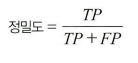


TP: 진짜 양성의 수 / FP: 거짓 양성의 수

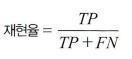

FN: 거짓 음성의 수

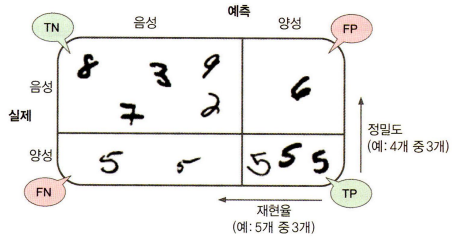

###3.3.3 정밀도와 재현율

In [27]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) #정밀도

0.8370879772350012

In [28]:
recall_score(y_train_5, y_train_pred) #재현율

0.6511713705958311

**F1 점수**: 정밀도와 재현율의 조화 평균, 두 분류기를 비교할 때 유용

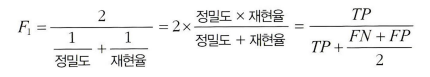

In [29]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred) #정밀도와 재현율이 비슷할 시 높게 측정

0.7325171197343846

###3.3.4 정밀도/재현율 트레이드오프

**정밀도/재현율 트레이드오프**: 정밀도를 올리면 재현율이 줄고 재현율을 올리면 정밀도가 줄어듬

(in SGDClassifier) 결정 함수를 사용하여 각 샘플의 점수를 계산

- 점수가 임계값보다 크면 샘플을 양성 클래스에 할당, 그렇지 않으면 음성 클래스에 할당



In [30]:
y_scores = sgd_clf.decision_function([some_digit]) #임계값을 직정 지정할 수는 없고 점수 확인만 가능
y_scores

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([2164.22030239])

In [32]:
threshold = 0 #임계값이 0이므로 predict()와 같은 결과를 반환
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [33]:
threshold = 8000 #임계값을 높이면 재현율이 줄어든다
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred


array([False])

In [34]:
#적절한 임계값 구하기 위해서는 모든 샘플의 점수를 구해야 함
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [37]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

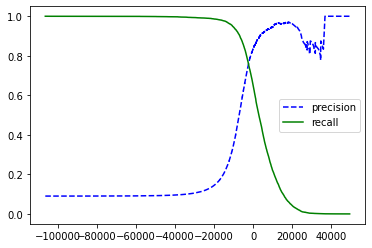

In [38]:
#임계값 함수로 정밀도와 재현율 그리기
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='recall')
    plt.legend()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show() #임계값을 올리더라도 정밀도가 가끔 낮아질 때가 있음

In [39]:
#정밀도 90% 달성을 목표로
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [40]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [43]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [44]:
recall_score(y_train_5, y_train_pred_90)
#재현율이 너무 낮음....

0.4799852425751706

###3.3.5 ROC 곡선

**ROC 곡선**: 위양성 비율(FPR), 진짜 양성 비율(TPR, 재현율)의 곡선

위양성 비율(FPR) = 1 - 진짜 음성 비율(TNR, 특이도)

따라서 ROC 곡선은 재현율에 대한 1-(특이도) 그래프

In [46]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

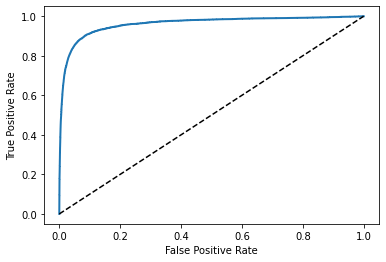

In [48]:
def plot_roc_curve(fpr, tpr, label = None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')

plot_roc_curve(fpr,tpr)
plt.show()

#점선은 완전한 랜덤 분류기의 ROC 곡선, 좋은 분류기일수록 이 점선에서 최대한 멀리 떨어져 있어야 함

**곡선 아래의 면적(AUC)**를 측정하여 분류기들을 비교

완벽한 분류기의 ROC의 AUC: 1 / 완전한 랜덤 분류기: 0.5

In [49]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

(in RandomForestClassifier) SGDClassifier의 ROC 곡선과 ROC AUC 점수를 비교

decision_function() 없고 predict_proba()는 가능

In [50]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [52]:
y_scores_forest = y_probas_forest[:,1] #양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

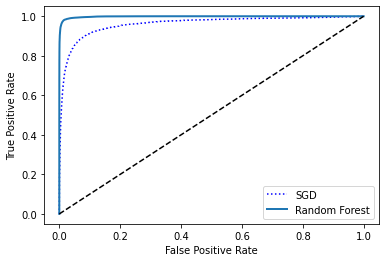

In [54]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

랜덤 포레스트 분류기가 SGD 분류기보다 훨씬 좋음!

In [55]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

###3.4 다중 분류

다중 분류기: 두 개 이상의 클래스를 구별

**OvR(OvA)**: 특정 숫자 하나만 구분하는 숫자별 이진 분류기 10개를 훈련, 이미지 분류 시 결정점수가 가장 높은 것을 클래스로 선택

**OvO**: 0과 1 구별, 0과 2 구별, 1과 2 구별 등 각 숫자의 조합마다 이진 분류기를 훈련, 클래스가 N개라면 분류기는 N*(N-1)/2개 필요, N*(N-1)/2개의 분류기를 통과해 가장 많이 양성으로 분류된 클래스를 선택

대부분 OvR 선호


In [56]:
#사이킷런이 알고리즘에 따라 자동으로 OvR 또는 OvO를 실행
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) #y_train_5가 아닌 y_train을 사용
svm_clf.predict([some_digit]) #OvO 이용

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


array([5], dtype=int8)

In [58]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores #5가 가장 높은 점수

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [59]:
np.argmax(some_digit_scores)

5

In [60]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [61]:
svm_clf.classes_[5]

5

In [57]:
#OvO나 OvR을 선택해서 사용하려면 OneVsOneClassifier나 OneVsRestClassfier 사용
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packa

array([5], dtype=int8)

In [62]:
len(ovr_clf.estimators_)

10

In [64]:
#SGDClassifier 훈련
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([3], dtype=int8)

In [65]:
#SGD 분류기는 다중 클래스로 분류가 가능
sgd_clf.decision_function([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [66]:
#교차검증
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [68]:
#데이터 전처리(입력의 스케일 조정)으로 정확도 향상
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

##3.5 에러 분석

In [ ]:
#가능성이 높은 모델을 하나 찾았다고 가정하고 모델 성능을 향상
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
#오차행렬을 이미지로 표현
plt.matshow(conf_mx, cmao=plt.cm.gray)
plt.show()

숫자 5가 다 숫자보다 어두움

-> 데이터 셋에 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못함

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [ ]:
#주대각선만 0으로 채워서 그래프를 그림
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()
#분류기가 만든 에러를 확실히 볼 수 있음

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

분류기는 이미지의 위치나 회전 방향에 민감함

-> 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리하여 에러 감소

##3.6 다중 레이블 분류

**다중 레이블 분류**: 여러 개의 이진 꼬리표를 출력하는 분류 시스템

In [ ]:
from sklearn.neighbors import KNeighborClassifier

y_train_large = (y_train >= 7) #7, 8, 9인지?
y_train_odd = (y_train%2 == 1) #홀수인지?
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
#예측을 생성
knn_clf.predict([some_digit])

In [ ]:
#각 레이블의 F1 score를 구하고 평균 점수를 계산
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='marco')

##3.7 다중 출력 분류

**다중 출력 다중 클래스 분류**: 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것

이미지에서 잡음을 제거하는 시스템 생성
- 각 레이블은 값을 여러개 가지기 때문에 다중 출력 분류 시스템!

In [ ]:
#픽셀 강도에 잡음을 추가
noise = np.random.randint(0,100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit) #타깃과 비슷